# Single Cell RNA Seq Data Analysis using Seurat_part_2

In [1]:
# load data
lung.seurat.obj <- readRDS("lung_seurat_NSCLC.rds")

In [2]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




### Clustering the Data

In [3]:
# Clustering the Data
lung.seurat.obj <- FindNeighbors(lung.seurat.obj, dims = 1:15)
lung.seurat.obj <- FindClusters(lung.seurat.obj, resolution = c(0.1, 0.3, 0.5, 0.7, 1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48149

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9674
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48149

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9166
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48149

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8791
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48149

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8465
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer ver

In [4]:
#set the identity of cells based on a specific resolution. For instance, at resolution 0.3
Idents(lung.seurat.obj) <- "RNA_snn_res.0.3"

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:44:51 UMAP embedding parameters a = 0.9922 b = 1.112

17:44:51 Read 1256 rows and found 15 numeric columns

17:44:51 Using Annoy for neighbor search, n_neighbors = 30

17:44:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:44:51 Writing NN index file to temp file /tmp/RtmpTKwXZA/file18794c1ca8a2

17:44:51 Searching Annoy index using 1 thread, search_k = 3000

17:44:51 Annoy recall = 100%

17:44:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

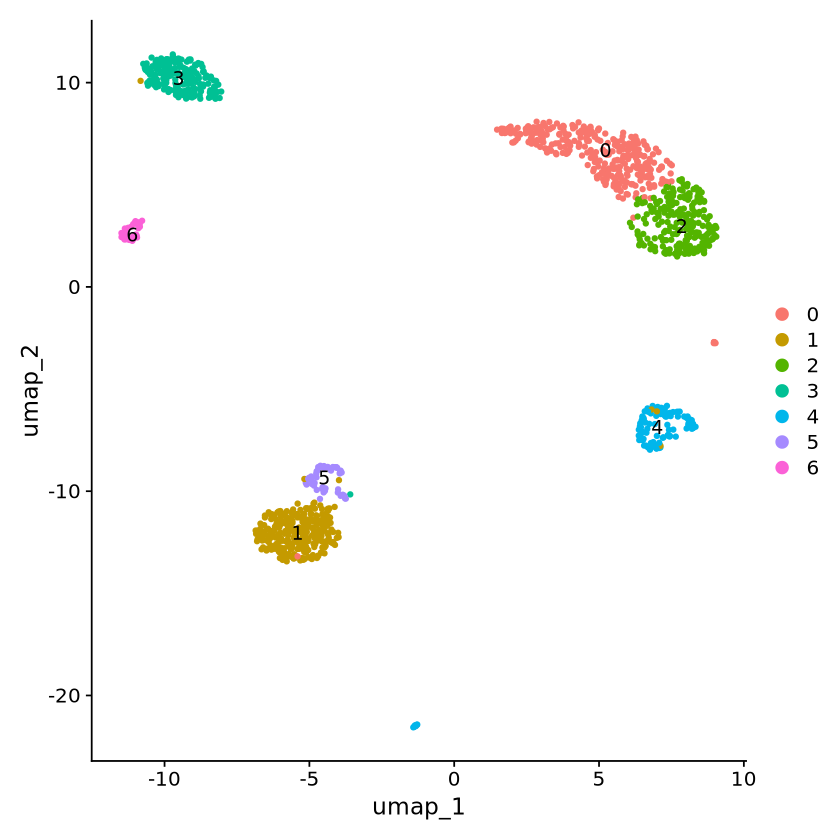

In [5]:
lung.seurat.obj <- RunUMAP(lung.seurat.obj, dims = 1:15)
# Plotting UMAP
DimPlot(lung.seurat.obj, reduction = "umap", label = TRUE)

## Cell Type Annotation

In [6]:
# Load necessary library
library(dplyr)
library(ggplot2)
library(SingleR)
library(celldex) # 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeigh

In [7]:
# Download a reference dataset from celldex.
# HumanPrimaryCellAtlasData is a common and robust choice.
ref.data <- HumanPrimaryCellAtlasData()

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


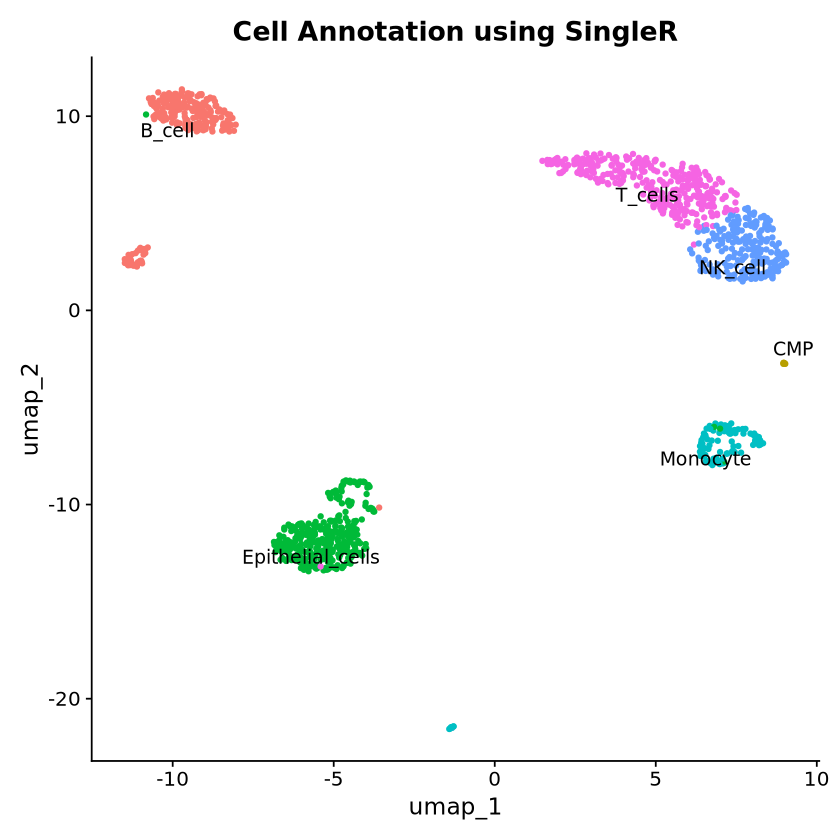

In [8]:
library(SingleR)

# Use RNA assay counts (or log-normalized counts)
expr.mat <- as.matrix(GetAssayData(lung.seurat.obj, slot = "data"))  # log-normalized
# or for raw counts
# expr.mat <- as.matrix(GetAssayData(lung.seurat.obj, slot = "counts"))

# 4. Run SingleR at cluster level (using Leiden clusters)
pred.cluster <- SingleR(
  test = expr.mat,
  ref = ref.data,
  labels = ref.data$label.main,
  clusters = lung.seurat.obj$seurat_clusters
)

# 5. Map cluster annotations back to cells
cluster.annotations <- pred.cluster$labels
names(cluster.annotations) <- rownames(pred.cluster)
cell.annotations <- cluster.annotations[as.character(lung.seurat.obj$seurat_clusters)]
names(cell.annotations) <- colnames(lung.seurat.obj)

# 6. Add to Seurat metadata
lung.seurat.obj <- AddMetaData(
  object = lung.seurat.obj,
  metadata = cell.annotations,
  col.name = "SingleR_cluster"
)

# 7. Visualize annotationsbb
DimPlot(lung.seurat.obj, group.by = "SingleR_cluster", label = TRUE, repel = TRUE) + NoLegend() + ggtitle("Cell Annotation using SingleR")

### Differential Expression Analysis for Each Cluster

In [9]:
# Differential expression analysis for each cluster
markers <- FindAllMarkers(lung.seurat.obj, only.pos = TRUE, logfc.threshold = 0.25)
#head(markers)


Calculating cluster 0

Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [10]:
# get top marker per cluster
top.markers <- markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
head(top.markers)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.370381e-12,8.111248,0.053,0.00,4.740762e-09,0,IL21
7.842005e-07,7.016415,0.026,0.00,1.568401e-03,0,CDO1
2.375878e-04,6.021993,0.015,0.00,4.751756e-01,0,AL157895.1
2.375878e-04,6.248362,0.015,0.00,4.751756e-01,0,LINC01229
1.016997e-03,6.246440,0.012,0.00,1.000000e+00,0,MS4A2
3.851225e-04,4.092769,0.102,0.05,7.702450e-01,1,AGR2


In [11]:
# 1. Make a table linking Seurat clusters to SingleR annotations
cluster_to_annotation <- lung.seurat.obj@meta.data %>%
  select(seurat_clusters, SingleR_cluster) %>%
  distinct() %>%
  arrange(seurat_clusters)

# 2. Join the markers with cluster annotations
markers_annotated <- markers %>%
  left_join(cluster_to_annotation, by = c("cluster" = "seurat_clusters"))

# 3. Select top 5 markers per annotated cell type (by avg_log2FC)
top_markers_per_celltype <- markers_annotated %>%
  group_by(SingleR_cluster) %>%
  slice_max(order_by = avg_log2FC, n = 5) %>%
  ungroup()

# 4. View
top_markers_per_celltype %>%
  select(SingleR_cluster, cluster, gene, avg_log2FC, pct.1, pct.2, p_val_adj)


SingleR_cluster,cluster,gene,avg_log2FC,pct.1,pct.2,p_val_adj
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
B_cell,2,KIR2DL4,7.906420,0.063,0.000,9.594905e-13
B_cell,2,SH2D1B,7.369539,0.045,0.000,1.491813e-08
B_cell,2,FGFBP2,7.270338,0.086,0.001,1.281320e-16
B_cell,2,KLRC3,7.247292,0.158,0.002,2.491030e-32
B_cell,2,AP000802.1,6.666591,0.027,0.000,2.366284e-04
Epithelial_cells,6,IGHV1-69D,11.638394,0.179,0.000,2.406723e-46
Epithelial_cells,6,IGHV1-18,11.529825,0.077,0.000,7.294059e-19
Epithelial_cells,6,IGHV4-39,11.063652,0.154,0.000,1.802627e-39
Epithelial_cells,6,IGKV1-39,10.856739,0.103,0.000,9.836998e-26


In [12]:
# Compare each SingleR-annotated cell type against all others
markers_celltype <- FindAllMarkers(
  object = lung.seurat.obj,
  group.by = "SingleR_cluster",
  only.pos = TRUE,
  logfc.threshold = 0.2,
  min.pct = 0.1
)

# View top markers per cell type
top_markers <- markers_celltype %>%
  group_by(cluster) %>%
  slice_max(order_by = avg_log2FC, n = 5) %>%
  ungroup() %>%
  select(cluster, gene, avg_log2FC, pct.1, pct.2, p_val_adj)

head(top_markers)

Calculating cluster B_cell

Calculating cluster Epithelial_cells

Calculating cluster Monocyte

Calculating cluster T_cells

Calculating cluster NK_cell

Calculating cluster CMP



cluster,gene,avg_log2FC,pct.1,pct.2,p_val_adj
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
B_cell,FCER2,7.498484,0.106,0.001,3.591484e-21
B_cell,IGHA2,7.418103,0.136,0.003,1.421174e-25
B_cell,IGHD,6.790651,0.114,0.003,8.473076e-21
B_cell,IGLC1,5.865894,0.258,0.092,7.954345e-09
B_cell,VPREB3,5.842465,0.487,0.005,9.550783e-111
Epithelial_cells,AGR2,5.297996,0.129,0.037,8.260917e-07
